# Machine Learning Algorithms

## 3. Gaussian Processes and Naive Bayes

### Gaussian Process Regression
 - Defines a prior over functions, which can be converted into a posterior over functions
 - We only need to be able to define a distribution over the function’s values at finite, arbitrary set of points... 
 - Consequently, GP is non-parametric (f(x) can be anything; unlike a linear regression with m and c values, there is an infinite amount of parameters to fit)
-  GPs can exhibit interpolating property and deliver probabilistic/confidence interval outputs

**Kernels in GP**
- Kernels (aka covariance functions' in the context of GPs) determine the shape of prior and posterior
- They encode assumptions on the function being learned by defining the *'similarity'* of two datapoints combined with the assumption that similar datapoints should have similar target values i.e. compute the GP’s covariance between datapoints
- Two categories: stationary kernels (depend only on the distance of two datapoints and not on their absolute values) and non-stationary, which are further be subdivided into isotropic (invariant to roatation) and anisotropic

Below is example displaying GPR with and without noise, attempting to estimate a y = x*sinx
- The noiseless case has no 'flexibility' or regularization, so leads to very large variances at the edges of the dataset range and very small, tight fits at the training points
- Play with the noise factor 'dy' to examine effect of noise and variation


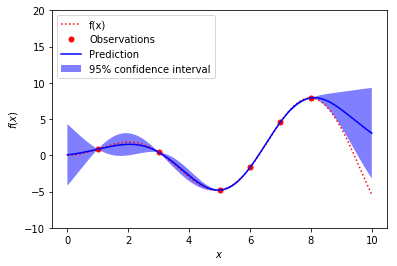

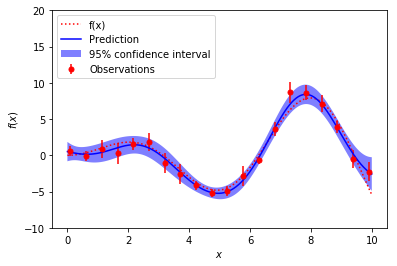

In [29]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

def f(x):                     # empirical function to estimate
    return x * np.sin(x)

# ---------------------------------------------------------------------------------------------------------------
#  1. Noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))                      # RBF ('squared exponential') kernel chosen 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using MLE
gp.fit(X, y)

# Make the prediction on the meshed x-axis 
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.plot(x, f(x), 'r:', label='f(x)')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')    # 1.96 => 1 std
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# -------------------------------------------------------------------------------------------------------------
# 2. Noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)                      # play with different levevls of noise
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                             n_restarts_optimizer=10)           # alpha is the regularizer... 

# Fit to data using MLE
gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

plt.figure()
plt.plot(x, f(x), 'r:', label='f(x)')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

The code below examines the GPs function fitting and interpolation ability

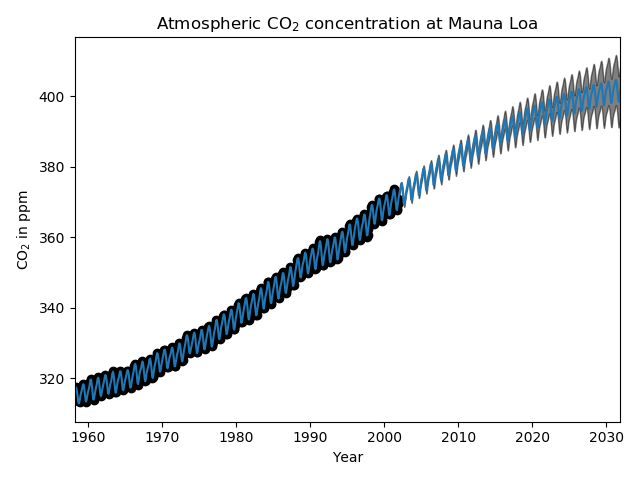

For probabilistic classification, GP Classifiers can be used. GaussianProcessClassifier implements the logistic link function (we can't have gaussian descirption for discrete class value) 

##### Advantages
- GP framework can take care of synthesizing the actual function empirically (only need to express belief of the function you want to model using the co-variance function)
- Inherently probablistic, used widely in Geostatistics
- Strong interpolatory ability 

##### Disadvantages
- O^3 complexity
***

### Naive Bayes (Classification)
- Generative model that is used purely for **classification** (produce a representation/abstraction of observed phenomena) that uses Bayes’ theorem with the ‘naïve’ assumption of conditional independence between every pair of features (somehow, have proven well despite this constraint)
- Probabilistic classifier that makes classifications using the Maximum A Posteriori decision rule in a Bayesian setting
- Widely used for text classification 

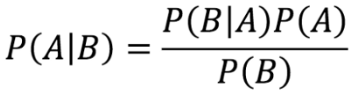

#### Gaussian Naive Bayes
- Extended to assume Gaussian distribution. Can calculate probability of an event based on the prior probabilities and conditions. Good a as a classifier, not as a predictor
- Mean and std. are estimated using maximum likelihood

Below is a little exercise to compare Naive Bayes against other classifiers:
- GaussianNaiveBayes tends to push probabilities to 0 or 1 (note the counts in the histograms). 
- Due to assumption that features are conditionally independent given the class

- Examine the effects of increasing n_redundant, hard classifying effect of NB drives histogram at the head/tails
- Contrast the SVM and RF behaviour which classify as positive after a certian 'threshold', but can't classify strongly as 0,1
 - RFs (bagging) are averaged and hence can't get perfect 1. SVC is hard boundary classifier so edges don't matter to it much (notice sensitivity in the middle) 
 
*Note: 'sigmoid' behaviour shows underconfidence, 'transposed-sigmoid' shows overconfidence*

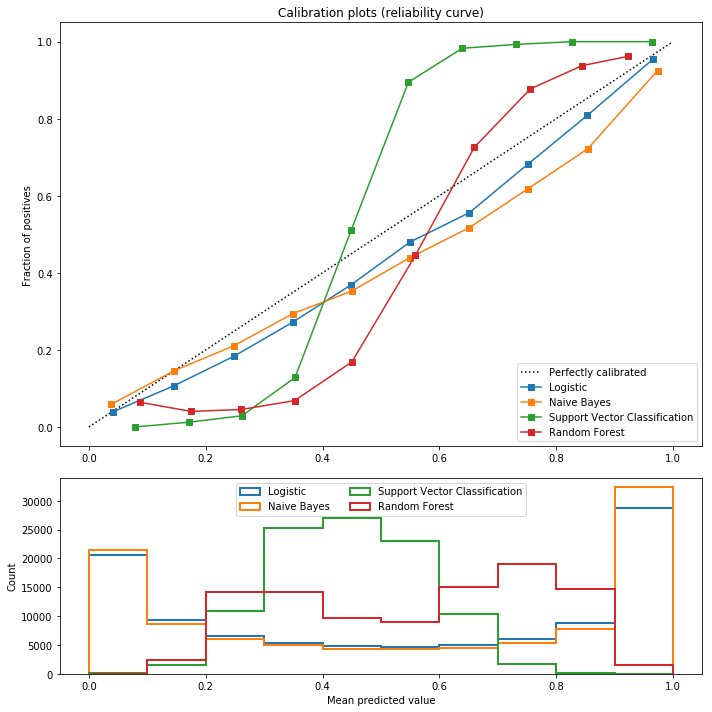

In [13]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=0)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)

# Plot calibration plots
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for clf, name in [(lr, 'Logistic'),                     # iteratively go through models
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    
    # Attempt to quantify classfication 
    if hasattr(clf, "predict_proba"):                   # if proba present...
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:                                               # ...else use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))
    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")                  # both x labels are mean predicted value
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

#### Other Naive Bayes
- Multinomial (2D array y), Bernoulli (features are binary) are some variants of other NB algorithms